In [1]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
n = 3000
kkk = 5000
dt = 0.01
#TT = np.zeros(kkk)
t = 0
D2R = ma.pi/180
R2D = 1/D2R
g = 9.81
i2 = 100
i3 = np.linspace(1,100,100)

In [3]:
VC_std_list = np.arange(1,20,0.1)
missdistance = np.zeros((len(VC_std_list),i2))
missdistance_avr = np.zeros(len(VC_std_list))

In [4]:
# Dimension
Dim = 2

# Initial Target Parameters
RT = np.zeros((kkk,Dim))
RT[0,:] = [0,5000]
BETA = np.zeros(kkk)
BETA[0] = -2*D2R
VT = 200                                                 
NT = -20
BETAD = np.zeros(kkk)
BETAD[0] = NT/VT

VT_array = np.zeros((kkk,Dim))
VT_array[0,:] = [-VT*ma.cos(BETA[0]), VT*ma.sin(BETA[0])]

# Initial Missile Parameters
RM = np.zeros((kkk,Dim))
RM[0,:] = [0,2000]
VM = 300                                                              
HEDEG = -40                                                                
NP = 4                                                                     
HE = HEDEG*D2R

VM_array = np.zeros((kkk,Dim))
NC_array = np.zeros((kkk,Dim))

NCR = np.zeros((2,kkk))
NCR_array = np.zeros((kkk,Dim))
NCR_0 = NCR[0,:]

VC = np.zeros(kkk)
LAMD = np.zeros(kkk)

# noise
VC_noise = 1
LAMD_noise = 0

# autopilot
autopilot = 0

zeta = np.sqrt(2)/2
omega = 10
A = np.array([[0, 1], [-omega**2, -2*zeta*omega]])
B = np.array([[0], [omega**2]])

# additional cal
RTM_array = RT - RM
RTM = np.linalg.norm(RTM_array[0,:])
RTM_final = np.zeros(kkk)
RTM_final[0] = RTM

LAM = ma.atan2(RTM_array[0,1], RTM_array[0,0])
LEAD = ma.asin(VT * ma.sin(BETA[0] + LAM) / VM)
THET = LAM + LEAD
VM_array[0,:] = VM * ma.cos(THET + HE), VM * ma.sin(THET + HE)
VTM_array = VT_array - VM_array
VC[0] = - (RTM_array[0,:] @ VTM_array[0,:].T) / RTM
LAMD[0] = (RTM_array[0,0]*VTM_array[0,1] - RTM_array[0,1]*VTM_array[0,0]) / (RTM*RTM)

NC = np.zeros(kkk)
NC[0] = NP * VC[0] * LAMD[0]

# NC limit
# if NC[0] > 4.5*g:
#     NC[0] = 4.5*g
# elif NC[0] < -4.5*g:
#     NC[0] = -4.5*g
# else:
#     NC[0] = NP * VC[0] * LAMD[0]

NC_array[0,:] = [-NC[0] * ma.sin(LAM),NC[0] * ma.cos(LAM)]

NCR[:,0] = (1.5*dt*B[:,0]*NC[0])

NCR_array[0,:] = [-NCR[0,1] * ma.sin(LAM), NCR[0,1] * ma.cos(LAM)]

for vv in range(len(VC_std_list)):
    
    std = VC_std_list[vv]
    
    for i1 in range(i2):
        for i in range(1,n):

            BETAD[i] = NT / VT
            BETA[i] = BETA[i-1] + 0.5*dt*(3*BETAD[i] - BETAD[i-1])

            VT_array[i,:] = [-VT*ma.cos(BETA[i]), VT*ma.sin(BETA[i])]

            if i == 1:
                RT[1,:] = RT[0,:] + 1.5*dt*VT_array[0,:]

                if autopilot == 1:
                    VM_array[1,:] = VM_array[0,:] + 1.5*dt*NCR_array[0,:]
                else:
                    VM_array[1,:] = VM_array[0,:] + 1.5*dt*NC_array[0,:]

                RM[1,:] = RM[0,:] + 1.5*dt*VM_array[0,:]

            else:

                RT[i,:] = RT[i-1,:] + 0.5*dt*(3*VT_array[i,:] - VT_array[i-1,:])

                if autopilot == 1:
                    VM_array[i,:] = VM_array[i-1,:] + 0.5*dt*(3*NC_array[i-1,:] - NC_array[i-2,:])
                else:
                    VM_array[i,:] = VM_array[i-1,:] + 0.5*dt*(3*NC_array[i-1,:] - NC_array[i-2,:])

                RM[i,:] = RM[i-1,:] + 0.5*dt*(3*VM_array[i,:] - VM_array[i-1,:])

            VTM_array = VT_array[i] - VM_array[i]
            RTM_array[i,:] = RT[i,:] - RM[i,:]
            RTM = np.linalg.norm(RTM_array[i,:])
            RTM_final[i] = RTM

            LAM = ma.atan2(RTM_array[i,1], RTM_array[i,0])
            VC[i] = - np.dot(RTM_array[i,:], VTM_array) / RTM + VC_noise * np.random.normal(0,std)
            LAMD[i] = (RTM_array[i,0]*VTM_array[1] - RTM_array[i,1]*VTM_array[0]) / (RTM*RTM) + LAMD_noise * np.random.normal(0,0.01)

            NC[i] = NP * VC[i] * LAMD[i]

            # NC limit
#             if NC[i] > 4.5*g:
#                 NC[i] = 4.5*g
#             elif NC[i] < -4.5*g:
#                 NC[i] = -4.5*g
#             else:
#                 NC[i] = NP * VC[i] * LAMD[i]

            NC_array[i,:] = [-NC[i] * ma.sin(LAM),NC[i] * ma.cos(LAM)]

            if autopilot == 1:

                if i == 1:
                    NCR[:,1] = (np.eye(2) + 1.5*dt*A)@NCR[:,0] + 1.5*dt*B[:,0]*NC[0]

                else:
                    NCR[:,i] = (np.eye(2) + 1.5*dt*A)@NCR[:,i-1] + 1.5*dt*B[:,0]*NC[i-1] - 0.5*dt*A@NCR[:,i-2] - 0.5*dt*B[:,0]*NC[i-2]

                NCR_array[i,:] = [-NCR[0,i] * ma.sin(LAM),NCR[0,i] * ma.cos(LAM)]

                NCR_0 = NCR[0,:]

            # condition
            if VC[i] <= 0:
                break   
                
        missdistance[vv,i1] = np.min(RTM_final[:i+1])
        #issdistance[vv,i1] = RTM_final[:i+1][-1]
        
    missdistance_avr[vv] = np.average(missdistance[vv])

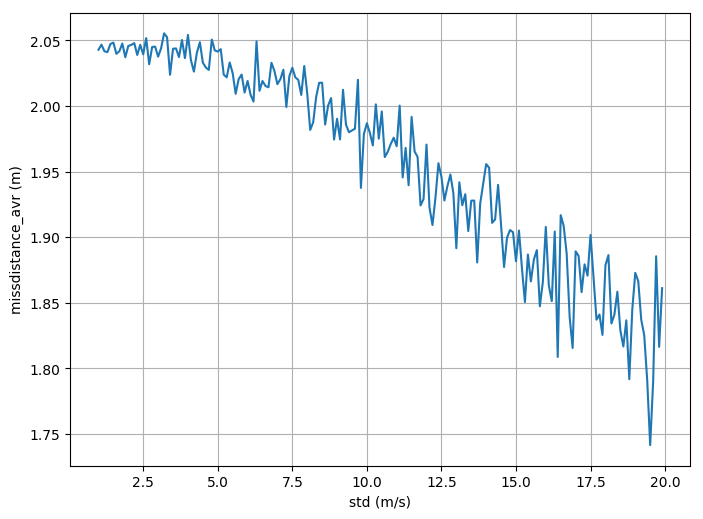

In [5]:
plt.figure(figsize=(8,6), dpi=100)
#plt.title('1')
plt.plot(VC_std_list, missdistance_avr)
#plt.axis('equal')
plt.xlabel('std (m/s)')
plt.ylabel('missdistance_avr (m)')
plt.grid()
plt.show()

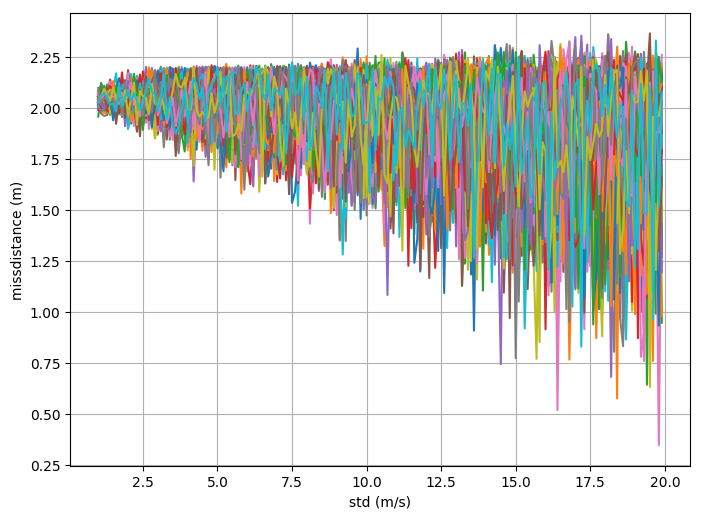

In [6]:
plt.figure(figsize=(8,6), dpi=100)
for i in range(100):
    plt.plot(VC_std_list, missdistance[:,i])
#plt.axis('equal')
plt.xlabel('std (m/s)')
plt.ylabel('missdistance (m)')
plt.grid()
plt.show()

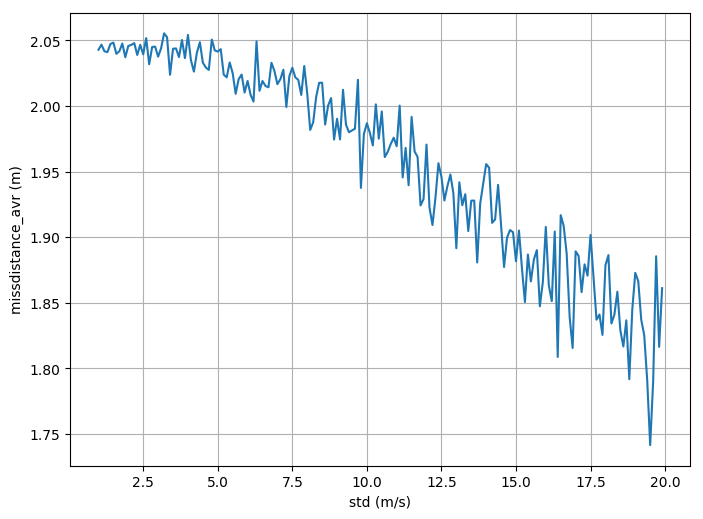

In [7]:
plt.figure(figsize=(8,6), dpi=100)
#plt.title('1')
plt.plot(VC_std_list, missdistance_avr)
#plt.axis('equal')
plt.xlabel('std (m/s)')
plt.ylabel('missdistance_avr (m)')
plt.grid()
plt.show()

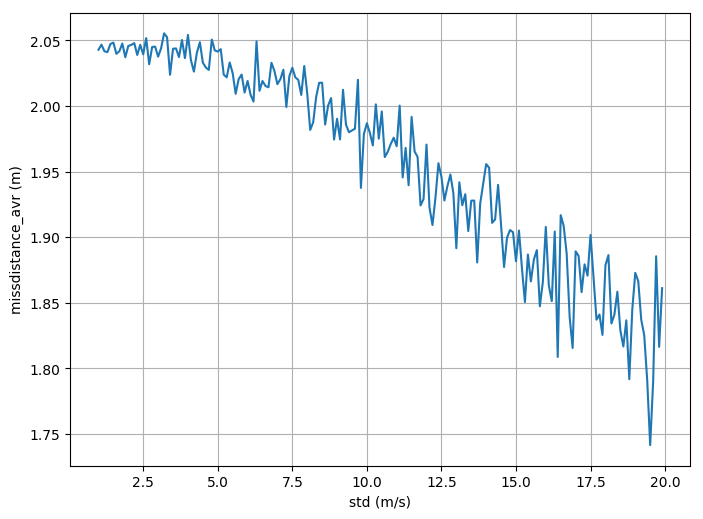

In [8]:
plt.figure(figsize=(8,6), dpi=100)
#plt.title('1')
plt.plot(VC_std_list, missdistance_avr)
#plt.axis('equal')
plt.xlabel('std (m/s)')
plt.ylabel('missdistance_avr (m)')
plt.grid()
plt.show()